In [126]:
# CMPT459 2020 spring
# milestone3
# randomforest classifier
# group name: Salt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score

def outlier_fd(data, threshold=0.5):
    low, high = np.percentile(data,1), np.percentile(data, 99)
    dist = high - low
    cut_off = dist * threshold
    lower, upper = low-cut_off, high+cut_off
    return [lower, upper]

def photos_number_counter(x):
    return len(x)

def valid_des(s):
    valid_s = " "
    for i in s.split():
        if i.isalnum():
            valid_s = " ".join([valid_s, i])
            
    return valid_s.strip()


In [2]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

# Data Preprocess

In [3]:
# data cleaned and feature selection and numericalization for classifier
ptrain = train
ptest = test
ptrain = ptrain.drop(['interest_level'], axis = 1)
pwhole = ptrain.append(ptest)

In [4]:
#Find the outlier of price, latitude and longitude using bound given by outlier_fd
[price_lower, price_higher] = outlier_fd(ptrain['price'])
[latitude_lower, latitude_higher] = outlier_fd(ptrain['latitude'],1)
[longitude_lower, longitude_higher] = outlier_fd(ptrain['longitude'],1)
#deal with outliers, set the column for modified data and plot again
pwhole['price_modify'] = pwhole['price']
pwhole['price_modify'].loc[pwhole['price_modify']<price_lower] = price_lower
pwhole['price_modify'].loc[pwhole['price_modify']>price_higher] = price_higher
#deal with outliers, set the column for modified data and plot again
pwhole['latitude_modify'] = pwhole['latitude']
pwhole['latitude_modify'].loc[pwhole['latitude_modify']<latitude_lower] = latitude_lower
pwhole['latitude_modify'].loc[pwhole['latitude_modify']>latitude_higher] = latitude_higher
#deal with outliers, set the column for modified data and plot again
pwhole['longitude_modify'] = pwhole['longitude']
pwhole['longitude_modify'].loc[pwhole['longitude']<longitude_lower] = longitude_lower
pwhole['longitude_modify'].loc[pwhole['longitude']>longitude_higher] = longitude_higher
#get the number of photos
pwhole['photos_number'] = pwhole['photos'].apply(photos_number_counter)
#set all feature words in tf_idf as features for train for feature_modify
pwhole['features_modify'] = pwhole['features'].apply(lambda x:" ".join(["_".join(i.split(" "))for i in x]))
counterf = CountVectorizer(max_features=100)
train_sparse_f = counterf.fit_transform(pwhole['features_modify'])
feature_list = counterf.get_feature_names()
array1 = train_sparse_f.toarray()
for i, feature_str in enumerate(feature_list):
    list_all = []
    [rows, cols] = array1.shape
    for row in range(rows):
        list_all.append(array1[row][i])
    feature_str_ = feature_str + '(f)'
    feature_v = pd.Series(list_all,pwhole.index, name = feature_str_)
    pwhole[feature_str_] = feature_v
#set all feature words in tf_idf as features for train for description_modify
pwhole['description_modify'] = pwhole['description'].apply(lambda x:valid_des(x))
counterd = CountVectorizer(stop_words=['features'], max_features=100)
train_sparse_d = counterd.fit_transform(pwhole['description_modify'])
description_list = counterd.get_feature_names()
array2 = train_sparse_d.toarray()
for i, description_str in enumerate(description_list):
    list_all = []
    [rows, cols] = array2.shape
    for row in range(rows):
        list_all.append(array2[row][i])
    description_str_ = description_str + '(d)'
    description_v = pd.Series(list_all,pwhole.index, name = description_str_)
    pwhole[description_str_] = description_v
## /*add something to change the created to year month day*/
pwhole['created']=pd.to_datetime(pwhole["created"])
pwhole['year']=pwhole['created'].dt.year
pwhole['month']=pwhole['created'].dt.month
pwhole['day']=pwhole['created'].dt.day

C:\AAA\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


feature selection

In [5]:
pwhole = pwhole.drop(['central_a(f)','in_super(f)','on(f)','pre(f)','war(f)'], axis = 1)
pwhole = pwhole.drop(['an(d)','and(d)','are(d)','as(d)','at(d)','be(d)','by(d)','can(d)','for(d)','from(d)','in(d)','is(d)','it(d)','just(d)','me(d)','more(d)','natural(d)','new(d)','or(d)','park(d)','that(d)','the(d)','this(d)','to(d)','will(d)','with(d)','you(d)','your(d)'], axis = 1)
# pwhole keep on dropping...
pwhole = pwhole.drop(["building_id", "created", "description", "display_address", "features", 
                     "manager_id", "photos", "street_address", "price", "longitude",
                        "latitude", "features_modify", "description_modify"], axis=1)

In [6]:
# get the polished version of train data and test data
# original: X_train.shape (49352, 176)    X_test.shape (74659, 176) X_train_label.shape (49352,3) high, low, medium
X_train = pwhole[:49352]
X_test = pwhole[49352:]
X_train = X_train.drop(['listing_id'], axis = 1)
X_test = X_test.drop(['listing_id'], axis = 1)
X_train_label = train['interest_level']
X_train_label.columns = [['interest_level']]




Now, we get three datasets: 
































training sampleset(without label) -- X_train
































test dataset -- X_test
































training labelset -- X_train_label
































Here,I list the columns of X_train to see all the features


In [9]:
X_train

,bathrooms,bedrooms,price_modify,latitude_modify,longitude_modify,photos_number,_photos(f),actual_apt(f),balcony(f),bike_room(f),...,supports(d),text(d),two(d),unit(d),west(d),windows(d),york(d),year,month,day
4,1.0,1,2400.0,40.7108,-73.9539,12,0,0,0,0,...,0,1,0,0,0,0,0,2016,6,16
6,1.0,2,3800.0,40.7513,-73.9722,6,0,0,0,0,...,0,1,0,0,0,0,0,2016,6,1
9,1.0,2,3495.0,40.7575,-73.9625,6,0,0,0,0,...,0,0,0,0,0,0,0,2016,6,14
10,1.5,3,3000.0,40.7145,-73.9425,5,0,0,0,0,...,0,0,0,0,0,0,0,2016,6,24
15,1.0,0,2795.0,40.7439,-73.9743,4,0,0,0,0,...,0,0,0,0,0,0,0,2016,6,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,2800.0,40.8433,-73.9396,5,0,0,0,0,...,1,0,0,0,0,0,1,2016,4,5
124002,1.0,2,2395.0,40.8198,-73.9578,5,0,0,0,0,...,0,0,0,0,0,0,1,2016,4,2
124004,1.0,1,1850.0,40.5765,-73.9554,3,0,0,0,0,...,0,0,0,0,0,0,0,2016,4,26
124008,1.0,2,4195.0,40.7448,-74.0017,5,0,0,0,0,...,0,0,0,1,0,0,0,2016,4,19


# 5-Fold Cross Validation

method 1

In [15]:
# reset index first
X_train = X_train.reset_index(drop=True)
X_train_label = X_train_label.reset_index(drop=True)
#5-fold cross validation
def new_cross_val_score(X_train, X_train_label, n_est):
    rkf = KFold(5,True,1)
    trainset_set = []
    trainlabel_set = []
    scores = []
    for train_index, test_index in rkf.split(X_train):
        print("train_index:{};\ntest_index:{}".format(train_index,test_index))
        #Xtrain: train part of tuples; Xtrainlabel: label of train part; Ytest: test part of tuples; Ytestlabel: label of test part
        Xtrain, Xtrainlabel = X_train.ix[train_index], X_train_label.ix[train_index]
        Ytest, Ytestlabel = X_train.ix[test_index], X_train_label.ix[test_index]
        cv_clf = RandomForestClassifier(n_estimators = n_est, n_jobs = -1)
        cv_clf.fit(Xtrain, Xtrainlabel)
        ypredict = cv_clf.predict_proba(Ytest)
        truelabel = pd.get_dummies(Ytestlabel)
        #print(truelabel)
        score = log_loss(truelabel, ypredict)
        trainset_set.append(Xtrain)
        trainlabel_set.append(Xtrainlabel)
        scores.append(score)
    print("scores for 5-fold:")
    print(scores)
    print("mean score:")
    print(np.mean(scores))

method 2

In [16]:
def fast_cross_val_score(X_train, X_train_label, n_est):
    clf = RandomForestClassifier(n_estimators = n_est, n_jobs = -1)
    scores = cross_val_score(clf, X_train, X_train_label, cv = 5, scoring = 'neg_log_loss')
    print("scores for 5-fold:")
    print(scores)
    print("mean score:")
    print(np.mean(scores))

# First Version Classcifier Performance

In the first version, I use the RandomForestClassifier with the parameters n-estimator = 500, others default

cross validation

In [17]:
new_cross_val_score(X_train, X_train_label, 500)

train_index:[    0     1     3 ... 49349 49350 49351];
test_index:[    2    10    12 ... 49327 49333 49348]


C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


train_index:[    0     1     2 ... 49348 49350 49351];
test_index:[    3     8    11 ... 49336 49346 49349]


C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


train_index:[    1     2     3 ... 49349 49350 49351];
test_index:[    0    13    16 ... 49338 49342 49347]


C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


train_index:[    0     2     3 ... 49349 49350 49351];
test_index:[    1     4     5 ... 49341 49344 49345]


C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


train_index:[    0     1     2 ... 49347 49348 49349];
test_index:[    9    14    15 ... 49343 49350 49351]


C:\AAA\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\AAA\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


scores for 5-fold:
[0.6381524295813675, 0.6479414358052011, 0.6465016554476584, 0.6524599218208798, 0.633053963545826]
mean score:
0.6436218812401866


In [18]:
fast_cross_val_score(X_train, X_train_label, 500)

scores for 5-fold:
[-0.62971614 -0.63424751 -0.64074313 -0.64552231 -0.65304628]
mean score:
-0.640655073441501


evaluation on the test data

In [74]:
xtrain, xval, ytrain, yval = train_test_split(X_train, X_train_label, test_size=0.2)

In [77]:
#validation
clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
clf.fit(xtrain, ytrain)
y_val_pred = clf.predict_proba(xval)
log_loss(yval, y_val_pred)

0.6466730771283339

In [80]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [78]:
#test performance
Y_prediction = clf.predict_proba(X_test)
y = pd.DataFrame(Y_prediction)
y.reset_index(drop = True, inplace = True)
ids = test['listing_id']
ids.reset_index(drop = True, inplace = True)
out = pd.concat([ids, y], axis = 1, ignore_index = True)
out.columns = ['listing_id', 'high', 'low', 'medium']
out = out[['listing_id', 'high', 'medium', 'low']]
submission_file = open("submission1.csv","w")
out.to_csv('submission1.csv', index = False)
submission_file.close()


On kaggle, the performance of first version gets score 0.64852 for private and 0.64591 for public

# Improvement

I'd adjust the parameters of the classifier first

Parameters defaulted:
RandomForestClassifier(bootstrap=True, criterion='gini',max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1, oob_score=False, random_state=None, 
                       verbose=0,warm_start=False)

Adjust max_depth

In [28]:
def max_depth_cv(X_train, X_train_label, para_max_depth):
    scores = {}
    for md in para_max_depth:
        print(md)
        clf = RandomForestClassifier(max_depth = md, n_jobs = -1, n_estimators = 100)
        score = cross_val_score(clf, X_train, X_train_label, cv = 5, scoring = 'neg_log_loss')
        scores[md] = np.mean(score)
    print("result for adjusting max_depth:")
    print(scores)

In [31]:
para_max_depth = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41]
max_depth_cv(X_train, X_train_label, para_max_depth)

3


C:\AAA\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
result for adjusting max_depth:
{3: -0.7531790567105536, 5: -0.7321888056349419, 7: -0.713371593703761, 9: -0.6977460787170793, 11: -0.6833754681288078, 13: -0.6699445210900036, 15: -0.6593240704654475, 17: -0.6507891132565697, 19: -0.6449313249725027, 21: -0.6417629432251071, 23: -0.6404744145814817, 25: -0.6415515267686159, 27: -0.6422967697939322, 29: -0.6443977471847134, 31: -0.6456614604652834, 33: -0.6510640706588104, 35: -0.6552356998682191, 37: -0.655746541265907, 39: -0.6600720937639348, 41: -0.6655498074968158}


From observation, take max_depth = 23

Adjust max_feature

In [34]:
def max_features_cv(X_train, X_train_label, para_max_features):
    scores = {}
    for mf in para_max_features:
        print(mf)
        clf = RandomForestClassifier(max_depth = 23, max_features = mf, n_jobs = -1, n_estimators = 100)
        score = cross_val_score(clf, X_train, X_train_label, cv = 5, scoring = 'neg_log_loss')
        scores[mf] = np.mean(score)
    print("result for adjusting max_features:")
    print(scores)

In [35]:
para_max_features = ['auto', 'sqrt']
max_features_cv(X_train, X_train_label, para_max_features)

auto
sqrt
result for adjusting max_features:
{'auto': -0.6409536629321785, 'sqrt': -0.6397373221299625}


From observation, take max_features = 'sqrt'

Adjust min_samples_leaf

In [38]:
def min_samples_leaf_cv(X_train, X_train_label, para_min_samples_leaf):
    scores = {}
    for msl in para_min_samples_leaf:
        print(msl)
        clf = RandomForestClassifier(max_depth = 23, max_features = 'sqrt', min_samples_leaf = msl, n_jobs = -1, n_estimators = 100)
        score = cross_val_score(clf, X_train, X_train_label, cv = 5, scoring = 'neg_log_loss')
        scores[msl] = np.mean(score)
    print("result for adjusting min_samples_leaf:")
    print(scores)

In [40]:
para_min_samples_leaf = [1,2,3,4,5]
min_samples_leaf_cv(X_train, X_train_label, para_min_samples_leaf)

1
2
3
4
5
result for adjusting min_samples_leaf:
{1: -0.6408824276773185, 2: -0.6387155812563519, 3: -0.639927523483716, 4: -0.6425412810398413, 5: -0.6445246238068332}


From observation, take min_samples_leaf = 2

Adjust min_samples_split

In [50]:
def min_samples_split_cv(X_train, X_train_label, para_min_samples_split):
    scores = {}
    for mss in para_min_samples_split:
        print(mss)
        clf = RandomForestClassifier(max_depth = 23, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = mss, n_jobs = -1, n_estimators = 100)
        score = cross_val_score(clf, X_train, X_train_label, cv = 5, scoring = 'neg_log_loss')
        scores[mss] = np.mean(score)
    print("result for adjusting min_samples_split:")
    print(scores)

In [51]:
para_min_samples_split = [2,3,4,5,6]
min_samples_split_cv(X_train, X_train_label, para_min_samples_split)

2
3
4
5
6
result for adjusting min_samples_split:
{2: -0.6381046200245849, 3: -0.6396821983132707, 4: -0.6393962050601412, 5: -0.6402418766724735, 6: -0.6405613628563733}


From observation, take min_sample_split = 2

Adjust n_estimators

In [52]:
def n_estimators_cv(X_train, X_train_label, para_n_estimators):
    scores = {}
    for ne in para_n_estimators:
        print(ne)
        clf = RandomForestClassifier(max_depth = 23, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_jobs = -1, n_estimators = ne)
        score = cross_val_score(clf, X_train, X_train_label, cv = 5, scoring = 'neg_log_loss')
        scores[ne] = np.mean(score)
    print("result for adjusting n_estimators:")
    print(scores)

In [53]:
para_n_estimators = [100, 200, 400, 800, 1000, 1200, 1400, 1600, 1800, 2000]
n_estimators_cv(X_train, X_train_label, para_n_estimators)

100
200
400
800
1000
1200
1400
1600
1800
2000
result for adjusting n_estimators:
{100: -0.6391772146662607, 200: -0.6377237299650621, 400: -0.636591891295198, 800: -0.6358188798452, 1000: -0.6356379280188815, 1200: -0.6358444269339177, 1400: -0.6357993089913887, 1600: -0.6356194622040698, 1800: -0.635542585644009, 2000: -0.6357002909343046}


From observation, take n_estimators = 1000

Modify the dataset and have several attempts

In [58]:
# X_train1 (49352, 17) X_test1 (74659, 17)
X_train1 = X_train[['bathrooms','bedrooms','price_modify','latitude_modify','longitude_modify','photos_number','cats_allowed(f)','children(f)','dogs_allowed(f)','doorman(f)','fitness(f)','wifi_access(f)','access(d)','fitness(d)','year','month','day']]
X_test1 = X_test[['bathrooms','bedrooms','price_modify','latitude_modify','longitude_modify','photos_number','cats_allowed(f)','children(f)','dogs_allowed(f)','doorman(f)','fitness(f)','wifi_access(f)','access(d)','fitness(d)','year','month','day']]
# X_train2 (49352, 7) X_test2 (74659, 7)
X_train2 = X_train[['price_modify','latitude_modify','longitude_modify','photos_number','cats_allowed(f)','dogs_allowed(f)','wifi_access(f)']]
X_test2 = X_test[['price_modify','latitude_modify','longitude_modify','photos_number','cats_allowed(f)','dogs_allowed(f)','wifi_access(f)']]

attempt 1

In [56]:
clf2 = RandomForestClassifier(max_depth = 23, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_jobs = -1, n_estimators = 1000, oob_score = True)
clf2.fit(X_train, X_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=23, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [57]:
#test performance - submission2
Y_prediction = clf2.predict_proba(X_test)
y = pd.DataFrame(Y_prediction)
y.reset_index(drop = True, inplace = True)
ids = test['listing_id']
ids.reset_index(drop = True, inplace = True)
out = pd.concat([ids, y], axis = 1, ignore_index = True)
out.columns = ['listing_id', 'high', 'low', 'medium']
out = out[['listing_id', 'high', 'medium', 'low']]
submission_file = open("submission2.csv","w")
out.to_csv('submission2.csv', index = False)
submission_file.close()

score = 0.63623/0.63288

attempt 2

In [63]:
# train for X_train1
clf3 = RandomForestClassifier(max_depth = 23, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_jobs = -1, n_estimators = 1000, oob_score = True)
clf3.fit(X_train1, X_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=23, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [64]:
#test performance - submission3
Y_prediction = clf3.predict_proba(X_test1)
y = pd.DataFrame(Y_prediction)
y.reset_index(drop = True, inplace = True)
ids = test['listing_id']
ids.reset_index(drop = True, inplace = True)
out = pd.concat([ids, y], axis = 1, ignore_index = True)
out.columns = ['listing_id', 'high', 'low', 'medium']
out = out[['listing_id', 'high', 'medium', 'low']]
submission_file = open("submission3.csv","w")
out.to_csv('submission3.csv', index = False)
submission_file.close()

score = 0.63518/0.63393

attempt 3

In [66]:
# train for X_train2
clf3.fit(X_train2, X_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=23, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [67]:
#test performance - submission4
Y_prediction = clf3.predict_proba(X_test2)
y = pd.DataFrame(Y_prediction)
y.reset_index(drop = True, inplace = True)
ids = test['listing_id']
ids.reset_index(drop = True, inplace = True)
out = pd.concat([ids, y], axis = 1, ignore_index = True)
out.columns = ['listing_id', 'high', 'low', 'medium']
out = out[['listing_id', 'high', 'medium', 'low']]
submission_file = open("submission4.csv","w")
out.to_csv('submission4.csv', index = False)
submission_file.close()

score = 0.67949/0.67659

feature selection again for dataset modification

In [71]:
# feature selection
fsclf = ExtraTreesClassifier()
fsclf = fsclf.fit(X_train, X_train_label)

C:\AAA\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [76]:
names = X_train.columns

In [80]:
sorted_features = sorted(zip(fsclf.feature_importances_, names), reverse=True)

In [81]:
print("Features sorted by their score:")
print(sorted_features)

Features sorted by their score:
[(0.0711695287695152, 'day'), (0.05450367870480839, 'price_modify'), (0.03906865567701848, 'month'), (0.029914051613752983, 'photos_number'), (0.029126974764303724, 'longitude_modify'), (0.029126692478852183, 'latitude_modify'), (0.02357405220973023, 'bedrooms'), (0.014396529195421618, 'apartment(d)'), (0.013824412291639521, 'of(d)'), (0.013220341547506018, 'hardwood_floors(f)'), (0.012713775495914553, 'no_fee(f)'), (0.0119409825455052, 'bedroom(d)'), (0.011931231693536973, 'on(d)'), (0.010800906258088537, 'renovated(d)'), (0.01068996246302428, 'call(d)'), (0.010634241706851675, 'large(d)'), (0.010621333146472865, 'hardwood(d)'), (0.01044539919707921, 'all(d)'), (0.01037712215793301, 'kitchen(d)'), (0.010366844055233854, 'great(d)'), (0.010363343231101819, 'building(d)'), (0.010256006161386524, 'laundry_in_building(f)'), (0.009621464018525965, 'bathrooms'), (0.00931708945566646, 'high(d)'), (0.00926987561848987, 'email(d)'), (0.009262111485168145, 'laund

In [91]:
feature_selected = [sorted_features[i][1] for i in range(100)]
feature_selected

['day',
 'price_modify',
 'month',
 'photos_number',
 'longitude_modify',
 'latitude_modify',
 'bedrooms',
 'apartment(d)',
 'of(d)',
 'hardwood_floors(f)',
 'no_fee(f)',
 'bedroom(d)',
 'on(d)',
 'renovated(d)',
 'call(d)',
 'large(d)',
 'hardwood(d)',
 'all(d)',
 'kitchen(d)',
 'great(d)',
 'building(d)',
 'laundry_in_building(f)',
 'bathrooms',
 'high(d)',
 'email(d)',
 'laundry(d)',
 'doorman(f)',
 'living(d)',
 'spacious(d)',
 'beautiful(d)',
 'located(d)',
 'east(d)',
 'one(d)',
 'no(d)',
 'contact(d)',
 'full(d)',
 'has(d)',
 'steel(d)',
 'elevator(f)',
 'stainless(d)',
 'text(d)',
 'room(d)',
 'unit(d)',
 'studio(d)',
 'private(d)',
 'close(d)',
 'marble(d)',
 'granite(d)',
 'closet(d)',
 'dishwasher(f)',
 'bathroom(d)',
 'laundry_in_unit(f)',
 'amazing(d)',
 'space(d)',
 'cats_allowed(f)',
 'steps(d)',
 'appliances(d)',
 'dogs_allowed(f)',
 'floors(d)',
 'schedule(d)',
 'available(d)',
 'west(d)',
 'have(d)',
 'size(d)',
 'two(d)',
 'access(d)',
 'central(d)',
 'floor(d)',
 'w

# Performance on Second Version (after modification)

In [94]:
#X_train3 from feature selection
X_train3 = X_train[feature_selected]
X_test3 = X_test[feature_selected]

In [96]:
# train for X_train3
clf3.fit(X_train3, X_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=23, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [98]:
def fast_cross_val_score(X_train, X_train_label, clf):
    scores = cross_val_score(clf3, X_train, X_train_label, cv = 5, scoring = 'neg_log_loss')
    print("scores for 5-fold:")
    print(scores)
    print("mean score:")
    print(np.mean(scores))

fast_cross_val_score(X_train3, X_train_label, clf3)

scores for 5-fold:
[-0.62473865 -0.6282091  -0.62706931 -0.63262806 -0.64356349]
mean score:
-0.6312417217954053


In [97]:
#test performance - submission5
Y_prediction = clf3.predict_proba(X_test3)
y = pd.DataFrame(Y_prediction)
y.reset_index(drop = True, inplace = True)
ids = test['listing_id']
ids.reset_index(drop = True, inplace = True)
out = pd.concat([ids, y], axis = 1, ignore_index = True)
out.columns = ['listing_id', 'high', 'low', 'medium']
out = out[['listing_id', 'high', 'medium', 'low']]
submission_file = open("submission5.csv","w")
out.to_csv('submission5.csv', index = False)
submission_file.close()

# Overfitting Check

From the parameter adjustment of 'max_depth' from the improvement part, I observed the overfitting case. Now analyse deeper and make a curve.

In [99]:
ofscores = []
for i in range(3,42,2):
    print(i)
    ofclf = RandomForestClassifier(max_depth = i, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_jobs = -1, n_estimators = 500, oob_score = True)
    ofscore = cross_val_score(ofclf,X_train3, X_train_label, cv=5, scoring = 'neg_log_loss').mean()
    ofscores.append(ofscore)

3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41


In [112]:
ofclf = RandomForestClassifier(max_depth = 60, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_jobs = -1, n_estimators = 500, oob_score = True)
ofscore = cross_val_score(ofclf,X_train3, X_train_label, cv=5, scoring = 'neg_log_loss').mean()
ofscores.append(ofscore)

No handles with labels found to put in legend.


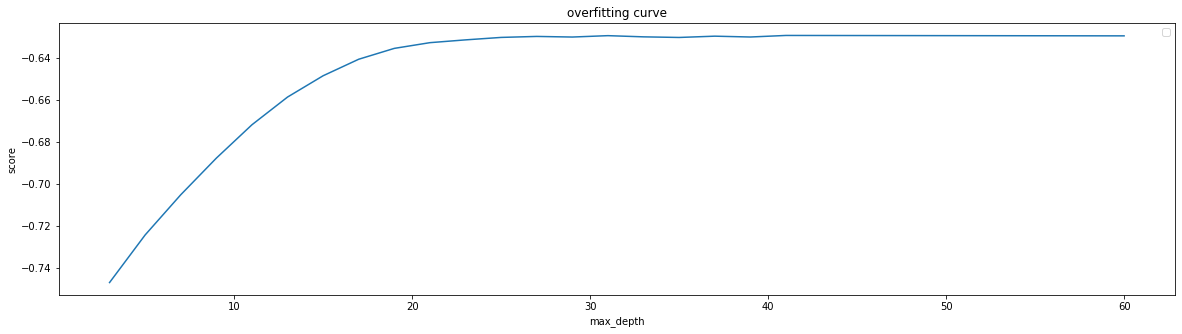

In [116]:
import math
modify_score = [score for score in ofscores]
length = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,60]
plt.figure(figsize=[20,5])
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('overfitting curve')
plt.plot(length,modify_score)
plt.legend()
plt.show()

# Confusion Matrix

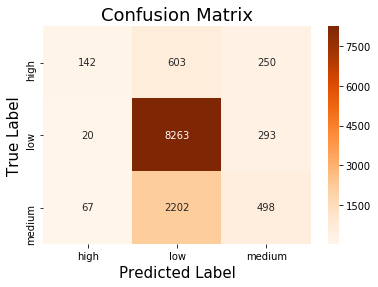

In [123]:
X_train5, X_valid, y_train, y_valid = train_test_split(X_train3,X_train_label)
clf3.fit(X_train5,y_train)
y_pred = clf3.predict(X_valid)
def cf_matrix(y_valid,y_pred):
    cm = confusion_matrix(y_valid, y_pred, labels = ['high','low','medium'])
    cm = pd.DataFrame(cm,columns=['high','low','medium'],index = ['high','low','medium'])
    plt.title('Confusion Matrix',fontsize=18)
    ax = sns.heatmap(cm,annot=True,cmap='Oranges',fmt='.20g',linewidths = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Label',fontsize=15)
    plt.ylabel('True Label',fontsize=15)
    
cf_matrix(y_valid,y_pred)

In [124]:
cm_result = confusion_matrix(y_valid, y_pred, labels = ['high','low','medium'])

In [125]:
cm_result

array([[ 142,  603,  250],
       [  20, 8263,  293],
       [  67, 2202,  498]], dtype=int64)

# Accuracy

In [127]:
 y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.5

In [133]:
#5-fold cross validation
def cross_val_score_ac(X_train3, X_train_label, clf3):
    rkf = KFold(5,True,1)
    scores = []
    for train_index, test_index in rkf.split(X_train3):
        print("train_index:{};\ntest_index:{}".format(train_index,test_index))
        #Xtrain: train part of tuples; Xtrainlabel: label of train part; Ytest: test part of tuples; Ytestlabel: label of test part
        Xtrain, Xtrainlabel = X_train3.ix[train_index], X_train_label.ix[train_index]
        Ytest, Ytestlabel = X_train3.ix[test_index], X_train_label.ix[test_index]
        clf3.fit(Xtrain, Xtrainlabel)
        ypredict = clf3.predict(Ytest)
        #print(truelabel)
        score = accuracy_score(Ytestlabel, ypredict)
        scores.append(score)
    print("scores for 5-fold using accuracy:")
    print(scores)
    print("mean score:")
    print(np.mean(scores))

cross_val_score_ac(X_train3, X_train_label, clf3)

train_index:[    0     1     3 ... 49349 49350 49351];
test_index:[    2    10    12 ... 49327 49333 49348]


C:\AAA\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\AAA\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


train_index:[    0     1     2 ... 49348 49350 49351];
test_index:[    3     8    11 ... 49336 49346 49349]


C:\AAA\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\AAA\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


train_index:[    1     2     3 ... 49349 49350 49351];
test_index:[    0    13    16 ... 49338 49342 49347]


C:\AAA\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\AAA\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


train_index:[    0     2     3 ... 49349 49350 49351];
test_index:[    1     4     5 ... 49341 49344 49345]


C:\AAA\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\AAA\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


train_index:[    0     1     2 ... 49347 49348 49349];
test_index:[    9    14    15 ... 49343 49350 49351]


C:\AAA\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\AAA\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


scores for 5-fold using accuracy:
[0.7245466518083274, 0.7179617060074968, 0.7252279635258359, 0.7113475177304964, 0.7185410334346505]
mean score:
0.7195249745013614
